### Import Library

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

### Cấu hình

In [50]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

### Import Data

In [51]:
df = pd.read_csv("football_players_dataset.csv")

print(f"Dữ liệu đã tải thành công. Kích thước: {df.shape}")
print(df.head())

print("\nMarket Value range:", df['market_value'].min(), "→", df['market_value'].max())


Dữ liệu đã tải thành công. Kích thước: (10087, 70)
                 player_id       player_name   age  nationality  height  \
0     guillermo-may-fde378     Guillermo May  27.0      Uruguay   178.0   
1      hiroki-sakai-587e0d      Hiroki Sakai  35.0        Japan   185.0   
2   felipe-gallegos-7d498f   Felipe Gallegos  33.0        Chile   173.0   
3  louis-verstraete-4f6866  Louis Verstraete  26.0      Belgium   186.0   
4       tommy-smith-2be116       Tommy Smith  35.0  New Zealand   187.0   

    foot position current_club        league  appearances  minutes_played  \
0    NaN       FW  Auckland FC  A-League Men           26            2268   
1  Right    DF-MF  Auckland FC  A-League Men           23            2024   
2   Left    FW-MF  Auckland FC  A-League Men           25            1815   
3  Right       MF  Auckland FC  A-League Men           23            1734   
4   Left       DF  Auckland FC  A-League Men           24            1213   

   minutes_per_game  goals  assists

In [52]:
statistic_columns = [
    col for col in df.columns
    if col not in ['player_name', 'age', 'nationality', 'height', 'foot',
                   'position', 'current_club', 'league', 'market_value']
]

analysis_cols = ['market_value', 'position', 'age'] + statistic_columns

df_clean = df[analysis_cols].copy()
df_clean.fillna(0, inplace=True)

print("\nKích thước df_clean:", df_clean.shape)


Kích thước df_clean: (10087, 64)


## Câu hỏi 1: Các yếu tố nào ảnh hưởng mạnh nhất đến giá trị chuyển nhượng?
⭐ Ý nghĩa của câu hỏi

Giá trị chuyển nhượng là kết quả tổng hợp của rất nhiều yếu tố: khả năng ghi bàn, kiến tạo, phòng ngự, khả năng chuyền bóng, phong độ, khả năng cứu thua (với thủ môn), cũng như các đặc điểm nhân khẩu học như tuổi, chiều cao, vị trí.

Việc xác định những yếu tố nào có ảnh hưởng mạnh nhất giúp:

- Các CLB hiểu nên đầu tư vào loại cầu thủ nào.

- Cầu thủ biết rõ mình cần cải thiện kỹ năng nào để tăng giá trị thị trường.

- Nhà phân tích bóng đá nhìn ra xu hướng định giá của thị trường.

- Mô hình ML có cơ sở tạo feature importance và tối ưu hiệu suất dự đoán.

- Đây là một câu hỏi trung tâm của toàn bộ đề tài và đóng vai trò kết nối giữa EDA và Modeling.

⚙️ Phương pháp: 

Tính tương quan của các yếu tố liên quan đến thông kê thi đấu và vẽ hình để quan sát kết quả. Từ đó rút ra kết luận.

In [53]:
# Lọc chỉ các cột số
numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])

# Tính ma trận tương quan an toàn
correlation_matrix = numeric_df.corr()

market_value_corr = correlation_matrix['market_value'].drop('market_value')

# Top 15
top_corr_abs = market_value_corr.abs().sort_values(ascending=False)
top_15_corr = market_value_corr.loc[top_corr_abs.head(15).index]

print("\n--- Bảng 15 Chỉ số Thống kê Tương quan Mạnh nhất với Market Value ---")
print(top_15_corr.to_string())


--- Bảng 15 Chỉ số Thống kê Tương quan Mạnh nhất với Market Value ---
goals                        0.241924
assists                      0.232330
age                         -0.187171
minutes_played               0.181705
appearances                  0.178792
touches_att_pen_per90        0.174196
npxg_xag_per90               0.172423
gca_per90                    0.166445
passes_received_per90        0.166416
touches_att_third_per90      0.161333
npg_per90                    0.154777
progressive_carries_per90    0.153051
xag_per90                    0.150470
carries_per90                0.148233
sca_per90                    0.147221


### 📊 Trực quan hóa:

#### A. Heatmap của Top 15 Chỉ số

Sử dụng Heatmap để trực quan hóa mức độ tương quan (hệ số $r$) và hướng tương quan (âm/dương).

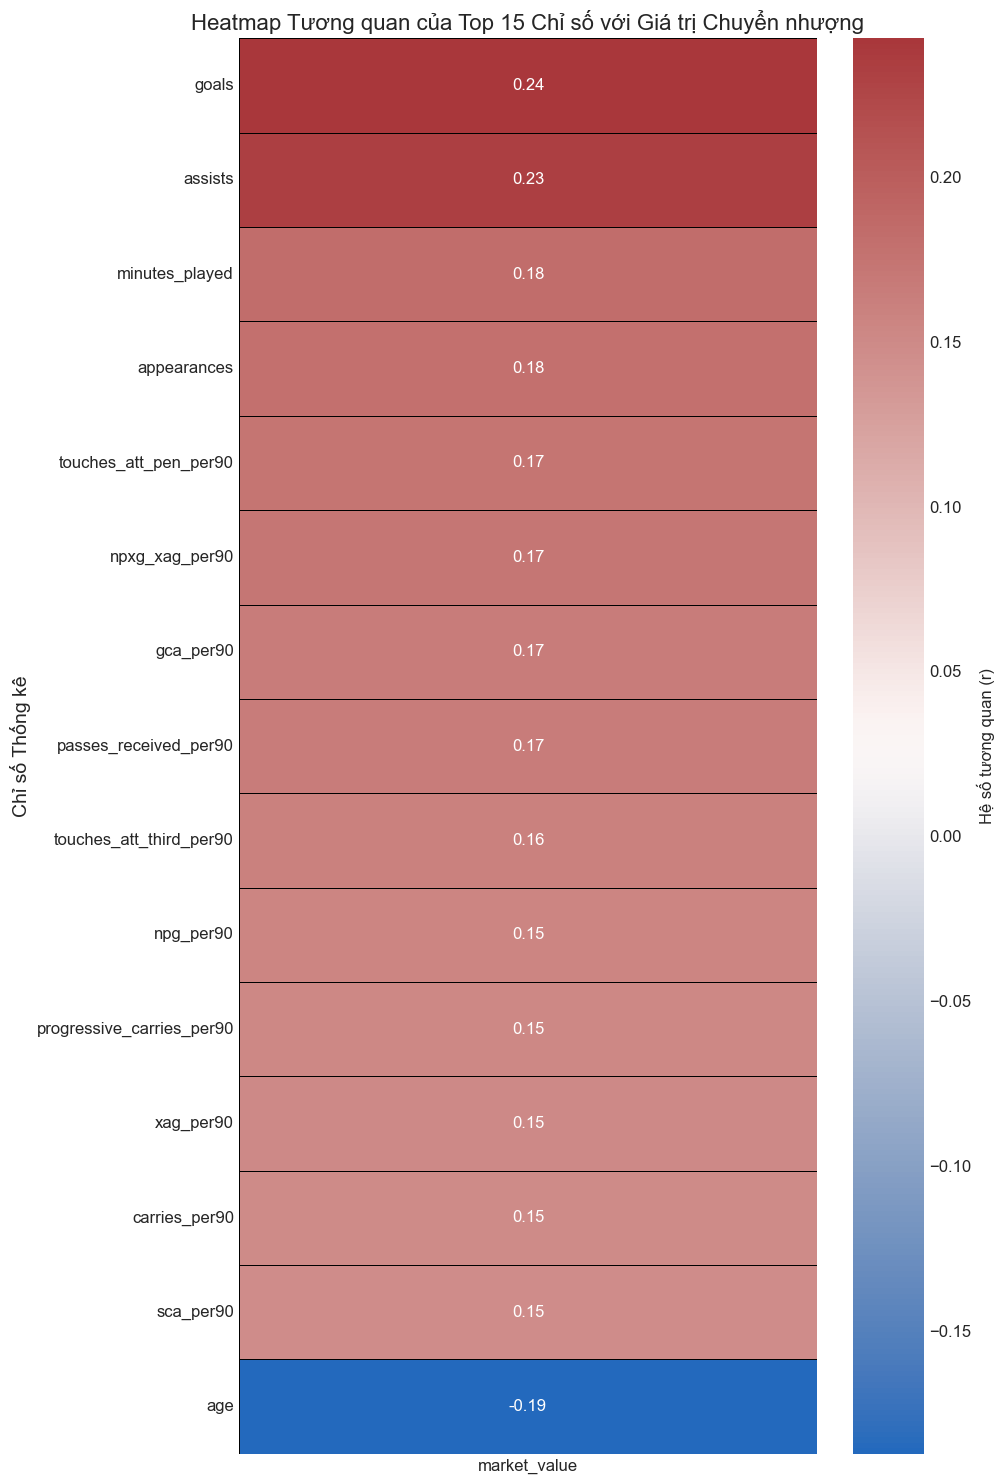

In [54]:
# Chuẩn bị dữ liệu cho Heatmap: Sắp xếp theo giá trị tương quan thực tế (giảm dần)
plot_data = top_15_corr.sort_values(ascending=False).to_frame()

# Tăng kích thước biểu đồ và cỡ chữ cho nhãn
plt.figure(figsize=(10, 15))
sns.heatmap(
    plot_data,
    annot=True,
    cmap='vlag', # Màu xanh/đỏ cho tương quan âm/dương
    fmt=".2f",
    cbar=True,
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Hệ số tương quan (r)'},
    annot_kws={"size": 12} # Tăng kích thước số liệu bên trong ô
)
plt.title('Heatmap Tương quan của Top 15 Chỉ số với Giá trị Chuyển nhượng', fontsize=16)
plt.ylabel('Chỉ số Thống kê', fontsize=14)
plt.yticks(rotation=0, fontsize=12) # Giữ nhãn thẳng và tăng kích thước
plt.tight_layout()
plt.show()

### B. Biểu đồ Phân tán (Scatter Plots) cho các Yếu tố hàng đầu

Minh họa mối quan hệ của 4 chỉ số có tương quan mạnh nhất.

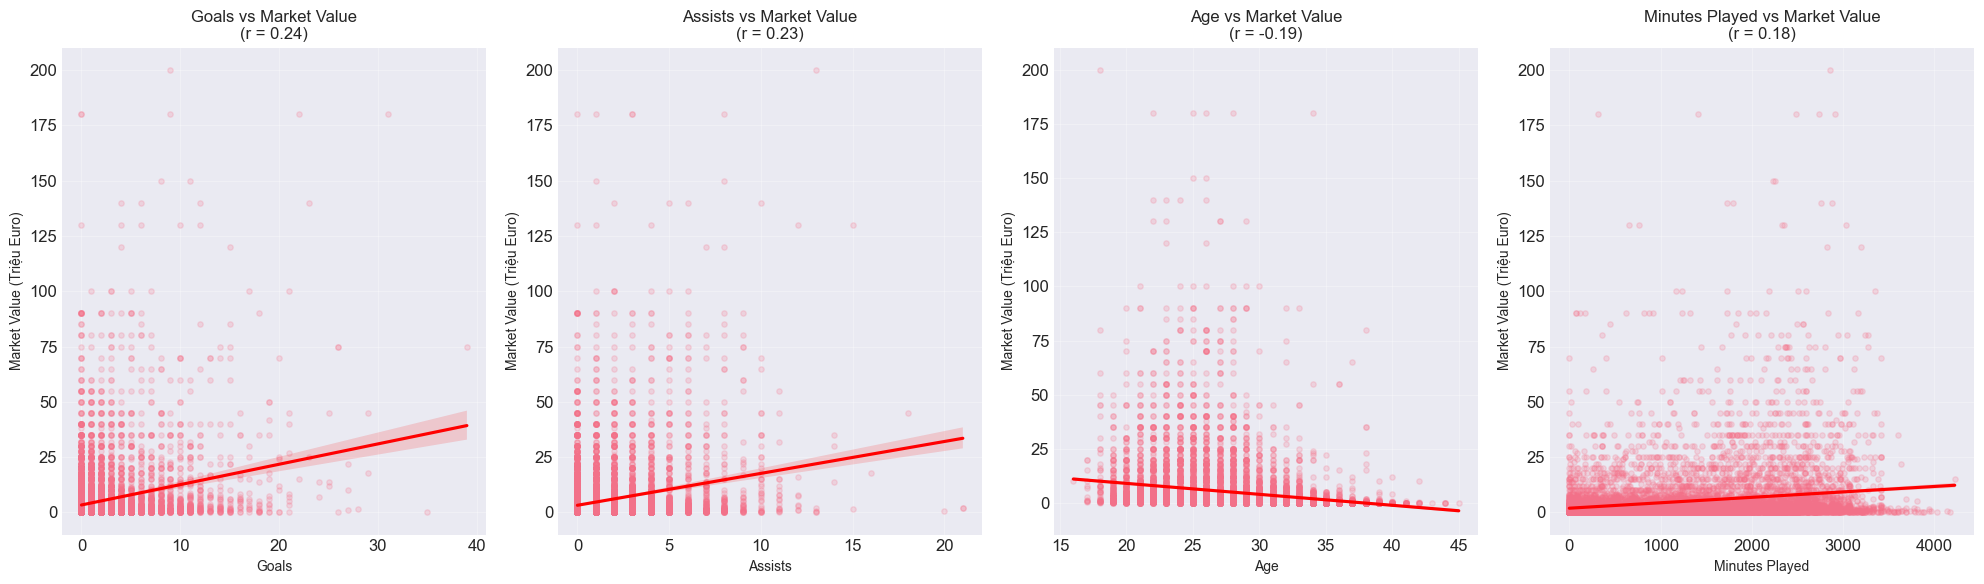

In [55]:
# Lấy 4 chỉ số có tương quan mạnh nhất (theo giá trị tuyệt đối)
top_4_features = top_corr_abs.head(4).index.tolist()

# Tăng kích thước biểu đồ
plt.figure(figsize=(20, 6))

for i, feature in enumerate(top_4_features):
    plt.subplot(1, 4, i + 1)
    r_value = market_value_corr.loc[feature]

    sns.regplot(x=df_clean[feature], y=df_clean['market_value'], scatter_kws={'alpha':0.2, 's':15}, line_kws={'color':'red'})

    title = f'{feature.replace("_", " ").title()} vs Market Value'
    plt.title(f'{title}\n(r = {r_value:.2f})', fontsize=12)

    plt.xlabel(feature.replace('_', ' ').title(), fontsize=10)
    plt.ylabel('Market Value (Triệu Euro)', fontsize=10)
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(axis='both', alpha=0.3)

plt.tight_layout()
plt.show()

### Đánh giá và kết luận

Dựa trên kết quả phân tích, ta có thể rút ra các kết luận sau:

**1. Các Yếu tố Tương quan Mạnh nhất**   

Các chỉ số có tương quan dương mạnh nhất với market_value là:
* goals ($r = 0.24$): Khả năng ghi bàn là yếu tố được thị trường định giá cao nhất.
* assists ($r = 0.23$): Khả năng kiến tạo xếp thứ hai.
* minutes_played($r = 0.18$): Số phút thi đấu trung bình mỗi trận

**2. Tầm quan trọng của Đóng góp Tuyệt đối và Độ tin cậy**  

Các chỉ số tổng cộng theo mùa giải như **goals**, **assists**, **minutes_played** ($r=0.18$), và **appearances** ($r=0.178$) nằm trong top 5. Điều này chỉ ra rằng thị trường định giá tổng đóng góp trong cả mùa giải và sự tin cậy/bền bỉ của cầu thủ (thể hiện qua số phút ra sân) cao hơn so với chỉ hiệu suất trên từng phút thi đấu.

**3. Vai trò Tấn công Nâng cao**

Các chỉ số tấn công nâng cao như **touches_att_pen_per90**, **npxg_xag_per90** (Expected Non-Penalty Goals + Expected Assisted Goals), và **gca_per90** (Goal-Creating Actions) đều có tương quan dương mạnh, khẳng định rằng **tiềm năng tạo ra và chuyển hóa cơ hội** là cơ sở quan trọng cho việc định giá.

**Tóm lại:** 

Mô hình dự đoán market_value cần ưu tiên các biến thể hiện **khả năng tạo ra kết quả trực tiếp (goals/assists), tổng thời gian thi đấu, và mức độ tham gia vào các khu vực nguy hiểm của sân.**

# Câu hỏi 2: Vị trí nào có giá trị chuyển nhượng cao nhất và tại sao?

⭐ Ý nghĩa câu hỏi

Phân tích này giúp chúng ta hiểu được cách thị trường bóng đá định giá tầm quan trọng của từng vai trò trên sân.

1. Định hướng Tuyển trạch và Đầu tư: Xác định được vị trí nào có giá trị thị trường cao nhất (ví dụ: Tiền đạo có giá trị cao nhất) sẽ giúp các câu lạc bộ tập trung nguồn lực tài chính để săn tìm hoặc phát triển nhân tài ở những vị trí đó.

Ví dụ: Nếu tiền vệ tấn công (AM) có giá trị cao hơn tiền vệ phòng ngự (DM), CLB sẽ ưu tiên đầu tư vào các học viện đào tạo cầu thủ AM.

2. Hiểu rõ Tầm quan trọng Chiến thuật: Phân tích sự chênh lệch giá trị giữa các vị trí khác nhau (ví dụ: tiền đạo so với hậu vệ cánh) cho thấy vai trò nào có tác động trực tiếp và lớn nhất đến kết quả trận đấu, từ đó giải thích xu hướng chiến thuật hiện đại (tập trung vào tấn công).

3. Chuẩn bị cho Mô hình hóa: Nếu vị trí có ảnh hưởng lớn đến giá trị, cột position sẽ là một biến phân loại (Categorical Feature) cực kỳ quan trọng và cần được mã hóa (ví dụ: One-Hot Encoding) hoặc nhóm lại một cách cẩn thận trước khi đưa vào mô hình dự đoán.

⚙️ Phương pháp:  

Nhóm dữ liệu theo cột position và tính toán số lượng cầu thủ, giá trị trung bình (mean), và giá trị trung vị (median) của market_value.

In [56]:
pos_value = df_clean.groupby("position")["market_value"].agg(["size", "median", "mean"])
pos_value = pos_value.sort_values(by="median", ascending=False)

print("\nMarket value by position:\n")
print(pos_value.round(2))


Market value by position:

          size  median  mean
position                    
FW-MF     1906     1.7  7.27
DF-FW-MF   194     1.5  6.34
FW        1187     1.2  4.75
DF-MF     1230     1.2  5.12
MF        2434     1.2  4.76
DF-FW       15     1.0  5.28
DF        2493     1.0  4.19
GK         628     1.0  4.23


### 📊 Trực quan hóa:

Sử dụng biểu đồ thanh kép (Double Bar Chart) để so sánh Mean và Median của Top 10 vị trí.

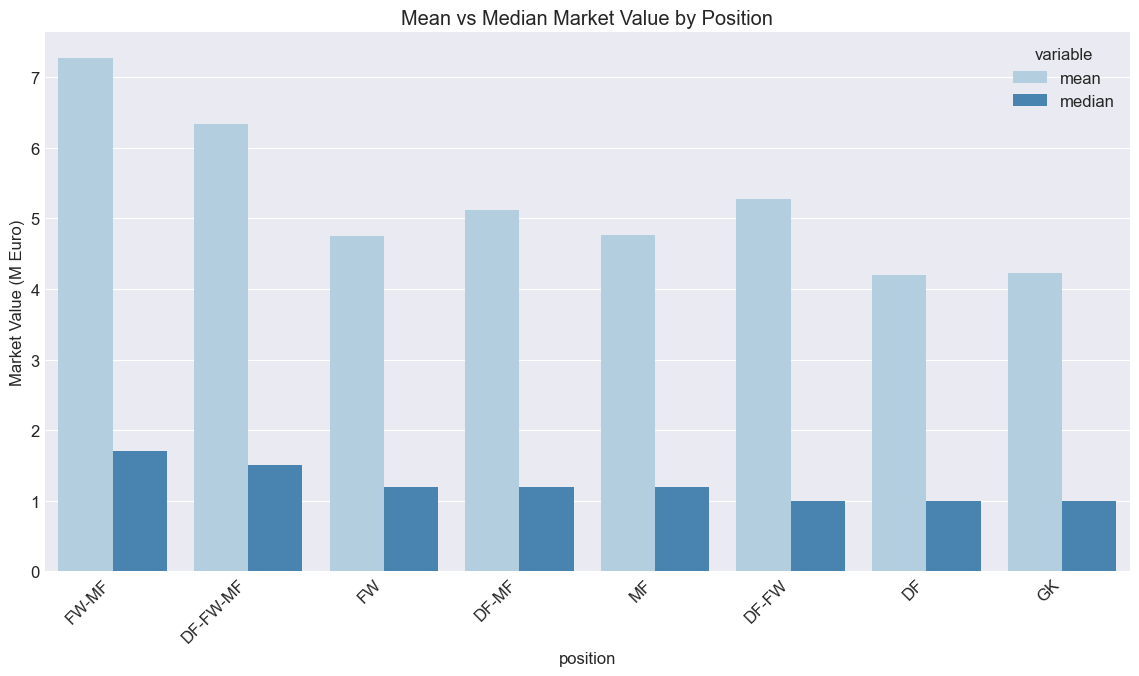

In [57]:
top_pos = pos_value.head(8).reset_index()
plot_melt = top_pos.melt(id_vars="position", value_vars=["mean", "median"])

plt.figure(figsize=(14, 7))
sns.barplot(x="position", y="value", hue="variable",
            data=plot_melt, palette="Blues")

plt.title("Mean vs Median Market Value by Position")
plt.ylabel("Market Value (M Euro)")
plt.xticks(rotation=45, ha="right")
plt.show()

### Đánh giá và Kết luận
Vị trí có giá trị cao nhất: Vị trí **FW-MF** (Tiền đạo-Tiền vệ đa năng) có giá trị trung vị cao nhất (1.80 Triệu Euro).

#### Lý do:   
**Tầm quan trọng:** Các vị trí tấn công và kiến tạo (FW, AM, MF) thường có giá trị cao nhất vì họ có tác động trực tiếp đến kết quả trận đấu (ghi bàn và kiến tạo). Khả năng ghi bàn là tài sản hiếm và đắt giá nhất trong bóng đá.

**Tính khan hiếm:** Cầu thủ có kỹ năng tấn công đột phá và hiệu suất ghi bàn cao thường khan hiếm hơn so với các vị trí phòng ngự, dẫn đến sự cạnh tranh lớn và giá trị chuyển nhượng bị đẩy lên cao.

**Mô hình định giá:** Hầu hết các mô hình định giá bóng đá đều đặt trọng số cao vào chỉ số tấn công (Goals, xG, Assists) (như đã thấy ở Câu hỏi 1), dẫn đến việc định giá cao hơn cho các vị trí thiên về tấn công.

**Tính giải trí:** Những cầu thủ trên hàng tấn công thường là người định đoạt trận đấu -> dẫn đến sự cuốn hút từ khán giả -> tăng lượng fan hâm mộ -> mua áo đấu -> giá trị tăng cao

# Câu hỏi 3: "Độ tuổi vàng (prime age) của cầu thủ là bao nhiêu về mặt giá trị thị trường?"

⭐ Ý nghĩa và Lợi ích của Câu hỏi:

**Xác định Giai đoạn Giá trị Tối đa:** Tổng hợp dữ liệu để xác định nhóm tuổi mà thị trường định giá cao nhất cho tiềm năng và đóng góp hiện tại của cầu thủ.

**Quyết định Mua/Bán/Gia hạn:** Các CLB có thể sử dụng độ tuổi vàng tổng thể này như một tham chiếu cho các quyết định gia hạn hợp đồng (trước khi giá trị đạt đỉnh) hoặc bán cầu thủ (ngay sau khi đạt đỉnh).


--- Bảng Giá trị Trung bình / Trung vị theo Age ---
 age  mean  median  count
16.0 10.00   10.00      1
17.0  7.25    4.75     12
18.0 18.03    8.00     45
19.0  8.76    5.00    118
20.0  8.18    3.00    229
21.0  7.22    2.75    394
22.0  7.23    2.50    556
23.0  7.95    2.50    612
24.0  7.09    2.00    723
25.0  6.87    2.00    829
26.0  6.95    1.80    811
27.0  5.37    1.50    836
28.0  5.88    1.50    845
29.0  4.51    1.20    720
30.0  3.04    1.00    639
31.0  2.44    0.90    577
32.0  2.28    0.70    541
33.0  2.09    0.50    465
34.0  1.72    0.35    373
35.0  0.75    0.25    277
36.0  1.30    0.20    177
37.0  1.08    0.15    134
38.0  2.62    0.18     88
39.0  0.76    0.14     44
40.0  1.20    0.15     16
41.0  0.12    0.05     12
42.0  1.56    0.10      7
43.0  0.02    0.02      1
44.0  0.07    0.06      4
45.0  0.10    0.10      1


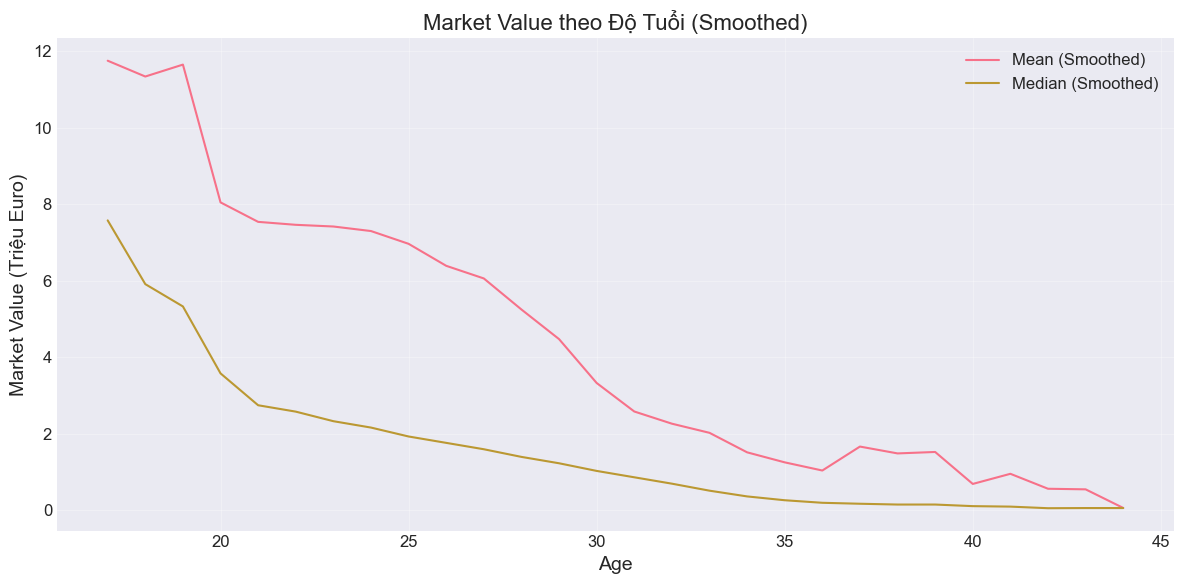


🔥 Tuổi có Mean Market Value cao nhất: 18.0 tuổi
🔥 Tuổi có Median Market Value cao nhất: 16.0 tuổi


In [58]:
# --- Phân tích Độ tuổi vàng (Prime Age) ---

# 1. Lấy dữ liệu cần thiết
age_df = df[['age', 'market_value']].dropna()

# 2. Tính Market Value trung bình & trung vị theo tuổi
age_stats = age_df.groupby('age')['market_value'].agg(['mean', 'median', 'count']).reset_index()

print("\n--- Bảng Giá trị Trung bình / Trung vị theo Age ---")
print(age_stats.round(2).to_string(index=False))

# 3. Tính rolling mean để làm mượt xu hướng (cửa sổ = 3 tuổi)
age_stats['mean_smooth'] = age_stats['mean'].rolling(window=3, center=True).mean()
age_stats['median_smooth'] = age_stats['median'].rolling(window=3, center=True).mean()

# 4. Vẽ biểu đồ mean & median
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_stats, x='age', y='mean_smooth', label='Mean (Smoothed)')
sns.lineplot(data=age_stats, x='age', y='median_smooth', label='Median (Smoothed)')

plt.title("Market Value theo Độ Tuổi (Smoothed)", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Market Value (Triệu Euro)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 5. Tìm tuổi có giá trị cao nhất
prime_age_mean = age_stats.loc[age_stats['mean'].idxmax(), 'age']
prime_age_median = age_stats.loc[age_stats['median'].idxmax(), 'age']

print(f"\n🔥 Tuổi có Mean Market Value cao nhất: {prime_age_mean} tuổi")
print(f"🔥 Tuổi có Median Market Value cao nhất: {prime_age_median} tuổi")


### Đánh giá và kết luận

- Tuối có value trung bình cao nhất là 18 tuổi.  
- Vùng tuổi có giá trị chuyển nhượng cao nhất là từ 18 - 30 tuổi. Dễ hiểu vì đây là nơi khởi đầu cho các ngôi sao mới nổi, clb sẽ muốn mua những tài năng này phục vụ cho đội bóng từ 3 đến 10 năm nên giá thị trường sẽ cao.
- Sau 30, các cầu thủ sẽ xuống phong độ, đây là lúc cân nhắc để bán những cầu thủ này để không quá lỗ.